# Data description & Problem statement: 
The dataset is related to red vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests. For more details, please check: https://archive.ics.uci.edu/ml/datasets/wine+quality
* Dataset is imbalanced. The data has 4898 rows and 12 columns.
* This is a classification problem. The classification goal is to predict wine quality based on physicochemical tests.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc. 
- Split data into training & test parts 
   #  Model Training:
- Build an initial RF model, and evaluate it via C-V approach
- Use grid-search along with C-V approach to find the best hyperparameters of RF model: Find the best RF model (Note: I've utilized SMOTE technique via imblearn toolbox to synthetically over-sample the minority category and even the dataset imbalances.)
   # Model Evaluation: 
- Evaluate the best RF model with optimized hyperparameters on Test Dataset, by calculating:
     - AUC score
     - Confusion matrix
     - ROC curve  
     - Precision-Recall curve 
     - Average precision
     
Finally, calculate the Feature Importance for the features 

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/wine quality/winequality-red.csv', sep=';') 

df['quality']=df['quality'].map({3:'L', 4:'L', 5:'L', 6:'L', 7:'H', 8:'H'})
df['quality']=df['quality'].map({'L':0,  'H':1})

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
# Function to remove outliers (all rows) by Z-score: 
def remove_outliers(X, y, name, thresh=3):
    L=[]
    for name in name:
        drop_rows = X.index[(np.abs(X[name] - X[name].mean()) >= (thresh * X[name].std()))]
        L.extend(list(drop_rows))
        
    X.drop(np.array(list(set(L))), axis=0, inplace=True)
    y.drop(np.array(list(set(L))), axis=0, inplace=True)
    print('number of outliers removed :  ' , len(L))

In [5]:
X=df.drop('quality', axis=1)
y=df['quality']

In [6]:
# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
# Removing outliers:
remove_outliers(X_train, y_train, ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
      'pH', 'sulphates', 'alcohol'], thresh=9)

number of outliers removed :   4


In [8]:
# Building the Initial Model & Cross-Validation: 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

model=RandomForestClassifier(max_features=5, n_estimators=20, max_depth=15,  random_state=42, class_weight='balanced')
kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores=cross_val_score(model, X_train, y_train, cv=kfold, scoring="roc_auc")

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.88683941 0.88658429 0.84914681 0.89114445 0.92748786] 

Accuracy: 0.89 (+/- 0.02)


In [9]:
# Grid-Search for the best model parameters: 

# Resampling:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

X_r, y_r = SMOTE().fit_sample(X_train, y_train)
#X_r, y_r = RandomOverSampler(random_state=0).fit_sample(X_train, y_train)


from sklearn.model_selection import GridSearchCV

param={'max_depth':[15, 22, 30], 'max_features':[2, 3, 6, 11], 'n_estimators': [30, 40, 70], 'min_samples_leaf':[1, 3]}

kfold=StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
grid_search=GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param, cv=kfold, n_jobs=-1, scoring="roc_auc")
grid_search.fit(X_r, y_r)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")
G.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
56,0.332859,0.004135,0.012468,0.000498,30,3,1,70,"{'max_depth': 30, 'max_features': 3, 'min_samp...",0.982723,...,0.989432,0.981757,0.004922,1,1.0,1.0,1.0,1.0,1.0,0.000000e+00
32,0.331114,0.003926,0.012966,0.000705,22,3,1,70,"{'max_depth': 22, 'max_features': 3, 'min_samp...",0.982656,...,0.989432,0.981740,0.004919,2,1.0,1.0,1.0,1.0,1.0,0.000000e+00
50,0.421622,0.017366,0.018450,0.002864,30,2,1,70,"{'max_depth': 30, 'max_features': 2, 'min_samp...",0.980921,...,0.993406,0.981704,0.007168,3,1.0,1.0,1.0,1.0,1.0,5.551115e-17


In [10]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'max_depth': 30, 'max_features': 3, 'min_samples_leaf': 1, 'n_estimators': 70}
Best validation accuracy:  0.98 (+/- 0.00)
Test score:  0.95


Confusion matrix, without normalization
[[313  34]
 [ 10  43]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.19 0.81]]


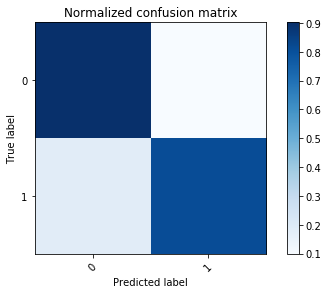

In [11]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

class_names=["0", "1"]
    
# Compute confusion matrix
cm = confusion_matrix(y_test, grid_search.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

In [12]:
# Classification report:
report=classification_report(y_test, grid_search.predict(X_test))
print(report)

             precision    recall  f1-score   support

          0       0.97      0.90      0.93       347
          1       0.56      0.81      0.66        53

avg / total       0.91      0.89      0.90       400



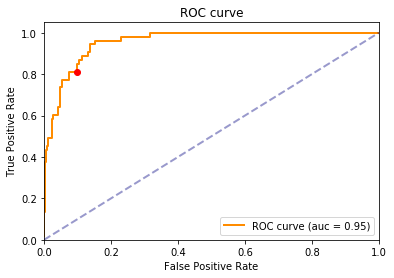

In [13]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test),grid_search.predict_proba(X_test)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), grid_search.predict_proba(X_test)[:, 1])

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

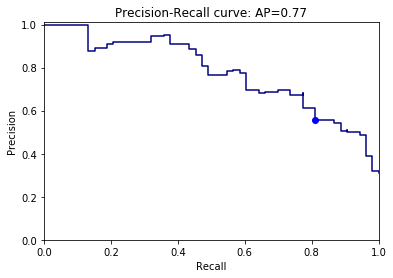

In [18]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test,grid_search.predict_proba(X_test)[:, 1],  pos_label=1)
ave_precision=average_precision_score(y_test,grid_search.predict_proba(X_test)[:, 1])

plt.step(recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0, 1.01])
plt.xlim([0, 1.001])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot(cm_normalized[1,1], cm[1,1]/(cm[1,1]+cm[0,1]), 'ob')
plt.show()

('alcohol', 0.4128573257756544)
('sulphates', 0.20197514749598544)
('volatile acidity', 0.11363167212738981)
('citric acid', 0.09518466318298774)
('total sulfur dioxide', 0.05409129220126527)
('density', 0.053598348155310636)
('chlorides', 0.024647158290442398)
('fixed acidity', 0.022059598387047026)
('residual sugar', 0.007893172476046154)
('pH', 0.007717528762696534)
('free sulfur dioxide', 0.006344093145174711)


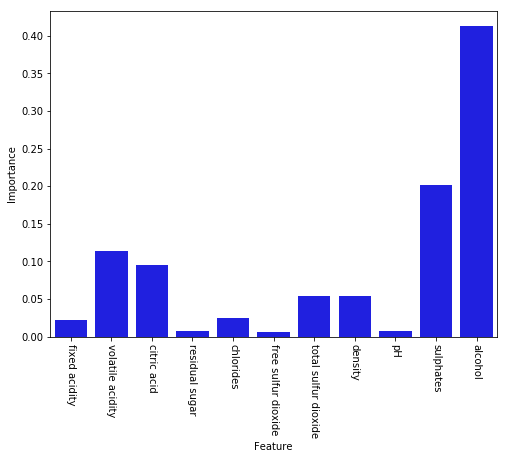

In [19]:
# Feature Importance:
im=RandomForestClassifier( max_depth= 3, max_features= 4, n_estimators= 25, random_state=42, class_weight="balanced").fit(X,y).feature_importances_

# Sort & Plot:
d=dict(zip(np.array(df.columns), im))
k=sorted(d,key=lambda i: d[i], reverse= True)
[print((i,d[i])) for i in k]

# Plot:
c1=pd.DataFrame(np.array(im),  columns=["Importance"])
c2=pd.DataFrame(np.array(df.columns[0:11]),columns=["Feature"])

fig, ax = plt.subplots(figsize=(8,6)) 
sns.barplot(x="Feature", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)
plt.xticks(rotation=-90)
plt.show()